# Система автоматической премодерации комментариев


Инструмент, который ищет токсичные комментарии и отправляет их на модерацию. 

Модель классифицирует комментарии на позитивные и негативные.

Целевая метрка - f1.

# 1. Подготовка

## Чтение

In [2]:
!pip install spacy -q 
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from tqdm import tqdm, tqdm_notebook, notebook

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

from scipy.sparse import hstack

import joblib

SEED=3021995

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
stop_words = stopwords.words('english')

In [5]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [6]:
display(data)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


Данные содержат только столбец с текстом и разметку токсичности комментариев.

Доля токсичных коментариев: 10.167888%


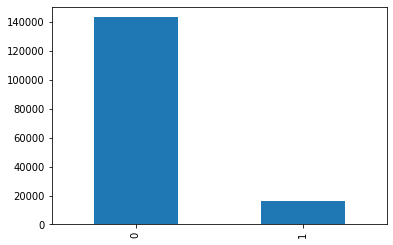

In [7]:
print('Доля токсичных коментариев: {:2%}'.format((len(data.query('toxic == 1'))/data.shape[0])))
data['toxic'].value_counts().plot(kind='bar')
plt.show()

Доля класса 1 в столбце токсичных коментариев - 10%,данные не сбалансированы.

## Предобработка

In [8]:
## мета признаки

def meta_features(data, stopwords):
    
    # всего слов
    data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))
    
    # уникальных слов
    data['unique_word_count'] = data['text'].apply(lambda x: len(set(str(x).split())))
    
    # стоп слов
    data['stop_word_count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

    # ссылок
    data['url_count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
  
    # средняя длина
    data['mean_word_length'] = data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    # всего символов
    data['char_count'] = data['text'].apply(lambda x: len(str(x)))
    
    return data

In [9]:
data = meta_features(data, stop_words)

In [10]:
display(data)
#print(len(data.query('url_count > 0')))

,text,toxic,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count
0,Explanation\nWhy the edits made under my usern...,0,43,41,18,0,5.162791,264
1,D'aww! He matches this background colour I'm s...,0,17,17,2,0,5.588235,112
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,20,0,4.571429,233
3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,56,0,4.486726,622
4,"You, sir, are my hero. Any chance you remember...",0,13,13,5,0,4.230769,67
...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,47,44,19,0,5.212766,295
159567,You should be ashamed of yourself \n\nThat is ...,0,18,18,11,0,4.388889,99
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,12,12,2,0,5.583333,81
159569,And it looks like it was actually you who put ...,0,25,23,15,0,3.680000,116


Мета признаки добавились в датасет корректно.

In [11]:
meta_features = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count']

TOXIC_COMMENTS = data['toxic'] == 1
UNTOXIC_COMMENTS = data['toxic'] == 0

In [12]:
#def show_feature_toxic(feature):
#    (data.loc[UNTOXIC_COMMENTS][feature]).plot(kind='bar', label='Not toxic', color='green')
#    (data.loc[TOXIC_COMMENTS][feature]).plot(kind='bar', label='Toxic', color='red')
#    plt.show()

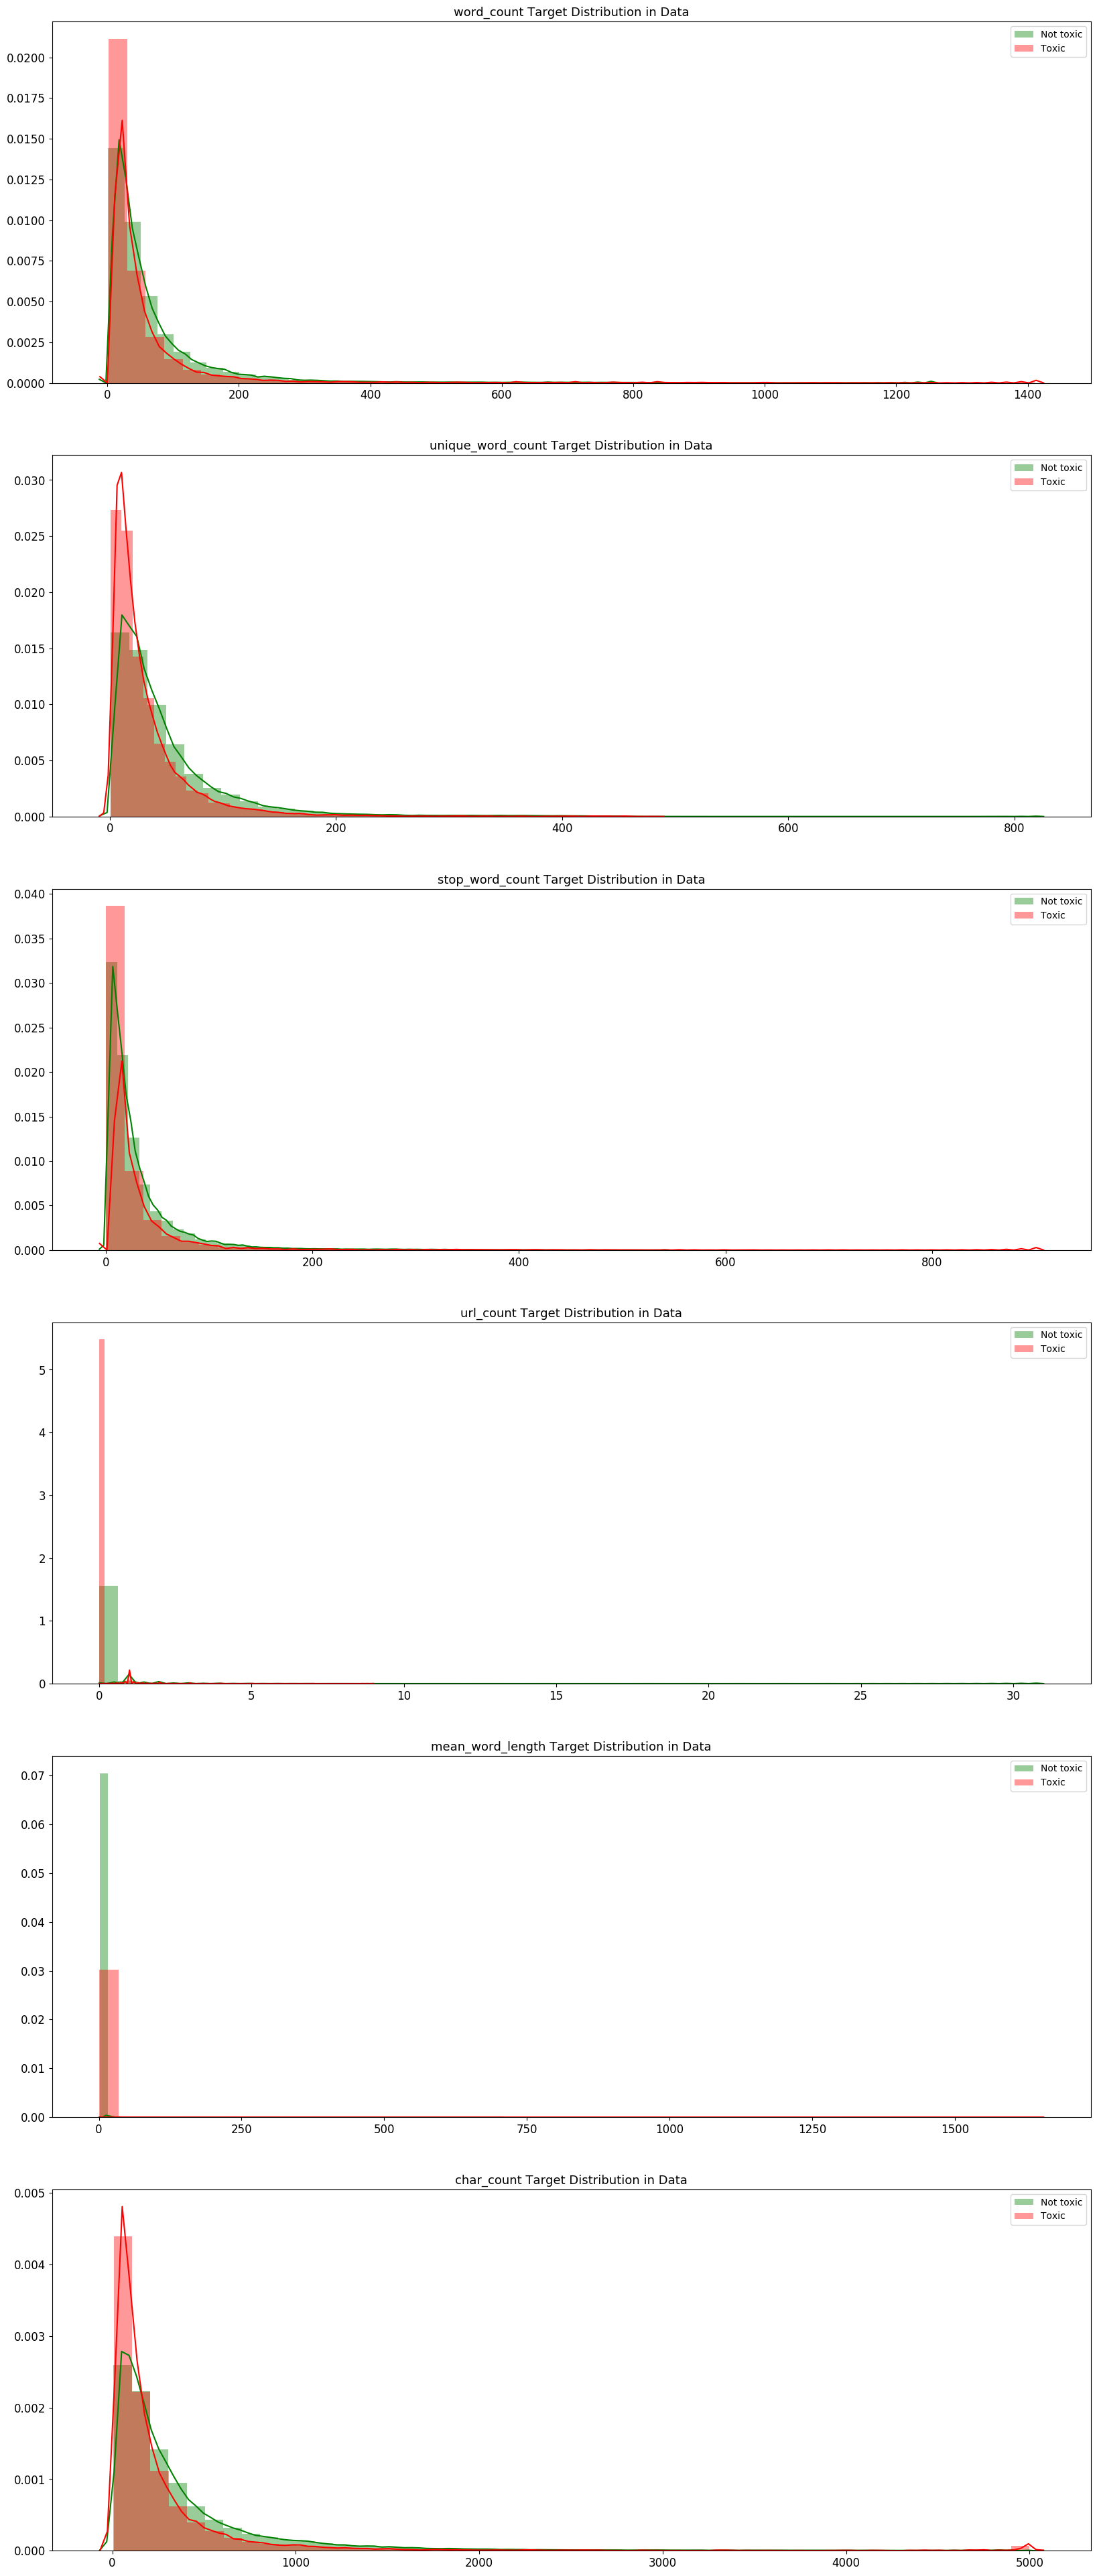

In [13]:
fig, axes = plt.subplots(ncols=1, nrows=len(meta_features), figsize=(20, 50), dpi=100)

for i, feature in enumerate(meta_features):
    sns.distplot(data.loc[UNTOXIC_COMMENTS][feature], label='Not toxic', ax=axes[i], color='green')
    sns.distplot(data.loc[TOXIC_COMMENTS][feature], label='Toxic', ax=axes[i], color='red')

    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()

    axes[i].set_title(f'{feature} Target Distribution in Data', fontsize=13)

plt.show()

### Вывод
Токсичные коментарии:
  - Чаще содежать меньшее кол-во уникальных слов
  - Чаще короче (и по символам, и словам)
  - Содержат меньшее кол-во стоп-слов
  

In [14]:
def clean(row):
    text = row['text']
    text = text.lower()
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    
    return text

In [15]:
data['text_clean'] = data.apply(clean, axis=1)

In [16]:
display(data.head(5))

,text,toxic,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,text_clean
0,Explanation\nWhy the edits made under my usern...,0,43,41,18,0,5.162791,264,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,17,17,2,0,5.588235,112,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,20,0,4.571429,233,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,56,0,4.486726,622,more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",0,13,13,5,0,4.230769,67,you sir are my hero any chance you remember wh...


## Лемматизация

In [19]:
nlp = en_core_web_sm.load()

In [20]:
def lemmatize(text):
    temp = []
    for token in nlp(text):
        if token.is_stop == False:
            temp.append(token.lemma_)
    return " ".join(temp)

In [21]:
tqdm.pandas()
data['text_lemma'] = data['text_clean'].progress_apply(lemmatize)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 159571/159571 [51:02<00:00, 52.10it/s] 


In [22]:
display(data[['text', 'text_lemma']].head(10))

,text,text_lemma
0,Explanation\nWhy the edits made under my usern...,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,daww match background colour be seemingly stic...
2,"Hey man, I'm really not trying to edit war. It...",hey man be try edit war guy constantly remove ...
3,"""\nMore\nI can't make any real suggestions on ...",not real suggestion improvement wonder secti...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page s
5,"""\n\nCongratulations from me as well, use the ...",congratulation use tool talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,cocksucker piss work
7,Your vandalism to the Matt Shirvington article...,vandalism matt shirvington article revert no...
8,Sorry if the word 'nonsense' was offensive to ...,sorry word nonsense offensive be intend write ...
9,alignment on this subject and which are contra...,alignment subject contrary dulithgow


# 2. Обучение

In [23]:
X = data.drop(columns=['toxic'])
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=SEED)
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train, y_train,
                                                                 shuffle=True,
                                                                 test_size=0.2,
                                                                 random_state=SEED)
print('Train_valid shapes:')
print(X_train_valid.shape, y_train_valid.shape)
print('Valid shapes:')
print(X_valid.shape, y_valid.shape)
print('Test shapes:')
print(X_test.shape, y_test.shape)

Train_valid shapes:
(102124, 9) (102124,)
Valid shapes:
(25532, 9) (25532,)
Test shapes:
(31915, 9) (31915,)


In [24]:
##подготовка признаков

vectorizer = TfidfVectorizer(ngram_range=(1, 1)) ## тк основной признак - текст
X_train_valid_left = vectorizer.fit_transform(X_train_valid['text_lemma'])
X_valid_left = vectorizer.transform(X_valid['text_lemma'])

scaler = StandardScaler() ##тк мета признаки - количественные
X_train_valid_right = scaler.fit_transform(X_train_valid[meta_features])
X_valid_right = scaler.transform(X_valid[meta_features])

X_train_valid_vec = hstack((X_train_valid_left, X_train_valid_right)) #объединяем
X_valid_vec = hstack((X_valid_left, X_valid_right))

## Модели

In [25]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=SEED, solver='liblinear'))
])



params = [
    {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'model': [LogisticRegression(random_state=SEED, solver='liblinear')],
        'model__C': [1, 10, 50, 100, 200]
    }#, #{
        #'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        #'model': [LGBMClassifier(boosting_type='gbdt', verbose=0, random_state=SEED, n_estimators=100)],
        #'model__num_leaves': [20, 31, 40],
        #'model__max_depth': [-1, 10, 20],
        #'model__learning_rate': [0.08, 0.1, 0.12]
    #}#, {
       #'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        #'model': [RandomForestClassifier(n_estimators=100, random_state=SEED)],
        #'model__max_features': np.linspace(0.1, 1, 5)
    #}
]


### считалось миллион лет(((( закоментировала

In [26]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=cv, verbose=True)

In [27]:
%%time
grid.fit(X_train_valid['text_lemma'], y_train_valid)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 21.2min finished


CPU times: user 15min 59s, sys: 6min 21s, total: 22min 20s
Wall time: 22min 24s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3021995, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                     

In [28]:
print(grid.best_params_)
print()
print(grid.best_score_)

{'model': LogisticRegression(C=200, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=3021995, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False), 'model__C': 200, 'vectorizer__ngram_range': (1, 2)}

0.770892947423585


Выбранная модель - Логистическая регрессия с параметрами с=200, при этом приобразования нграмм = (1,2).

In [33]:
print(y_test_pred.shape)
print(y_test.shape)

(31915,)
(31915,)


In [34]:
final_model = grid.best_estimator_
final_model.fit(X_train['text_clean'], y_train)
y_test_pred = final_model.predict(X_test['text_clean'])

In [35]:
print(y_test_pred.shape)

(31915,)


In [36]:
print('Конечный f1-score', f1_score(y_test, y_test_pred))

Конечный f1-score 0.7883633889077917


# 3. Выводы

- Для улучшения предсказаний модели в исходные данные были добавлены мета-признаки: длина сообщения, кол-во символом, кол-во уникальных слов, кол-во знаков препинания. Показано, что длина сообщения и кол-во уникальных слов характерны для токсичных сообщений.
- В качестве предобработки сообщений использовалась токенизация, лемматизация, удаление лишних символов, приведение к нижнему регистру.
- Лемматизация проводилась с помощью библиотеки.
- С помощью модели логистической регрессии удалось добиться f1-метрики более 0.75. При этом гиперпараметрымодели c=200, а векторные преобразования проводились на нграммах в 2 слова.

- вычислительные средства не позволили выполнить кросс валидацию на нескольких моделях, поэтому, возможно, метрика была бы еще выше.
- рекомендованную 